In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from flax import jax_utils
import jax
import ml_collections

import numpy as np
import matplotlib.pyplot as plt

import input_pipeline
import train
from configs import default as config_lib

In [2]:
tf.config.experimental.set_visible_devices([], "GPU")

In [3]:
# Load config that was used to train checkpoint.
import importlib

config_name = "default"
config = importlib.import_module(f'configs.{config_name}').get_config()

In [4]:
local_batch_size = config.batch_size // jax.process_count()
input_dtype = train.get_input_dtype(config.half_precision)

dataset_builder = tfds.builder(config.dataset)
dataset_builder.download_and_prepare()
train_iter = train.create_input_iter(
    dataset_builder,
    local_batch_size,
    config.image_size,
    input_dtype,
    train=True,
    cache=config.cache,
    ignore_label=config.ignore_label
    )
eval_iter = train.create_input_iter(
    dataset_builder,
    local_batch_size,
    config.image_size,
    input_dtype,
    train=False,
    cache=config.cache,
    ignore_label=config.ignore_label
)

1494 2988


In [5]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
        plt.axis('off')
    plt.show()

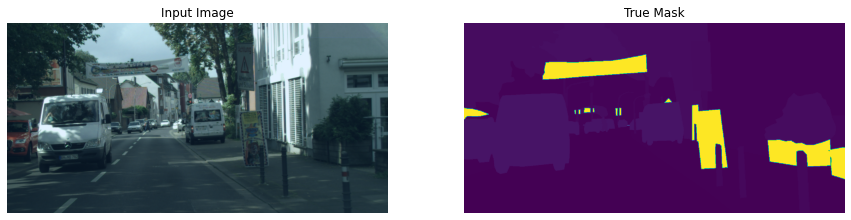

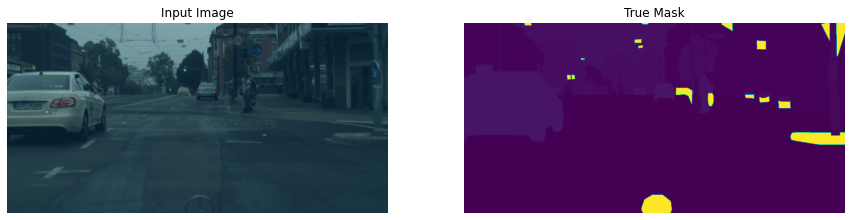

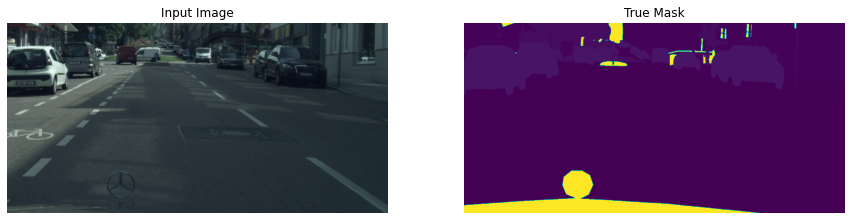

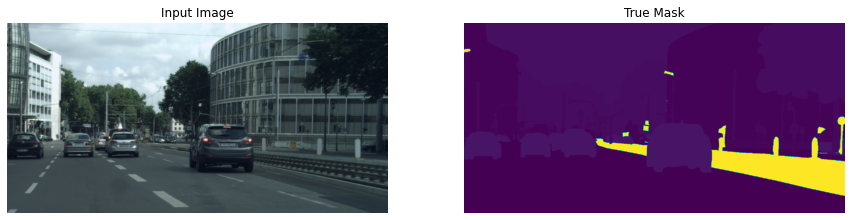

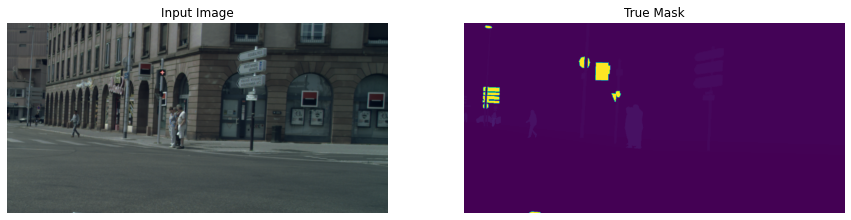

In [6]:
for _ in range(5):
    train_batch = next(train_iter)
    image = train_batch["image"]
    label = train_batch["label"]
    display([np.array(image[0]), np.array(label[0])])

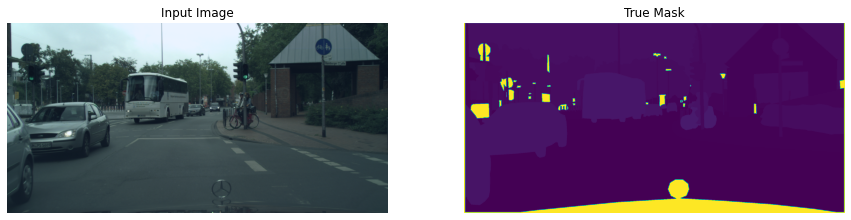

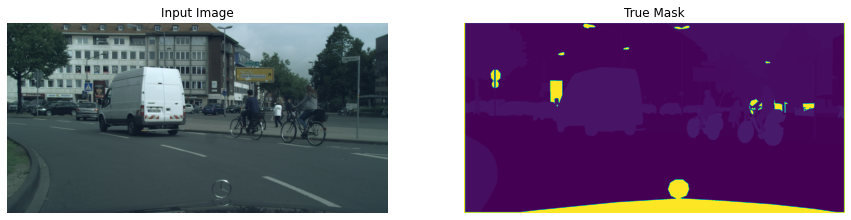

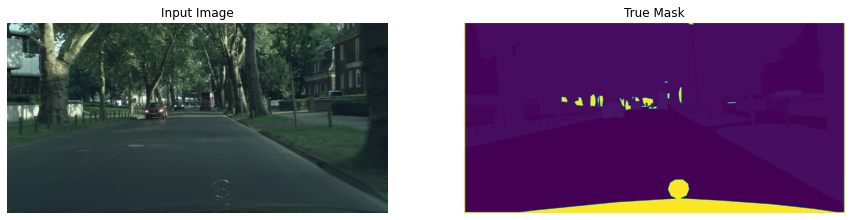

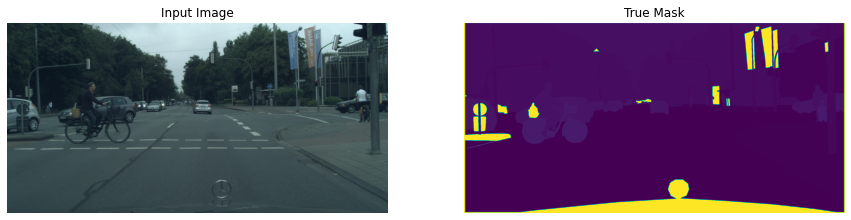

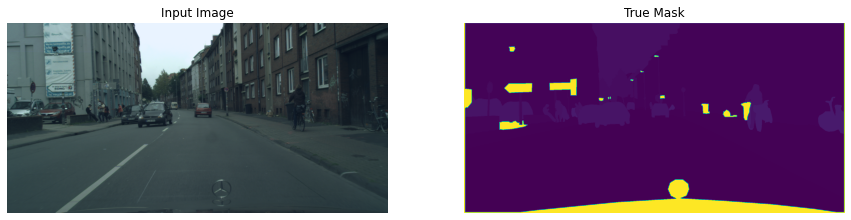

In [7]:
for _ in range(5):
    eval_batch = next(eval_iter)
    image = eval_batch["image"]
    label = eval_batch["label"]
    display([np.array(image[0]), np.array(label[0])])